In [10]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [3]:
# down.matplotlib_update_settings()
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')

In [4]:
f = h5py.File(os.path.join(tmpa_dir, 'data_tmpa_3h.hdf5'), "r")
print(list(f.keys()))
# print(list(f.attrs()))
tmpalat = f['lat'][:]
tmpalon = f['lon'][:]
dates_int = f['dates'][:]
hours_int = f['hours'][:]
dset = f['prcp']
print('dataset shape = {}'.format(dset.shape)) # too large to fit in memory!

['dates', 'hours', 'lat', 'lon', 'prcp']
dataset shape = (280, 112, 1085)


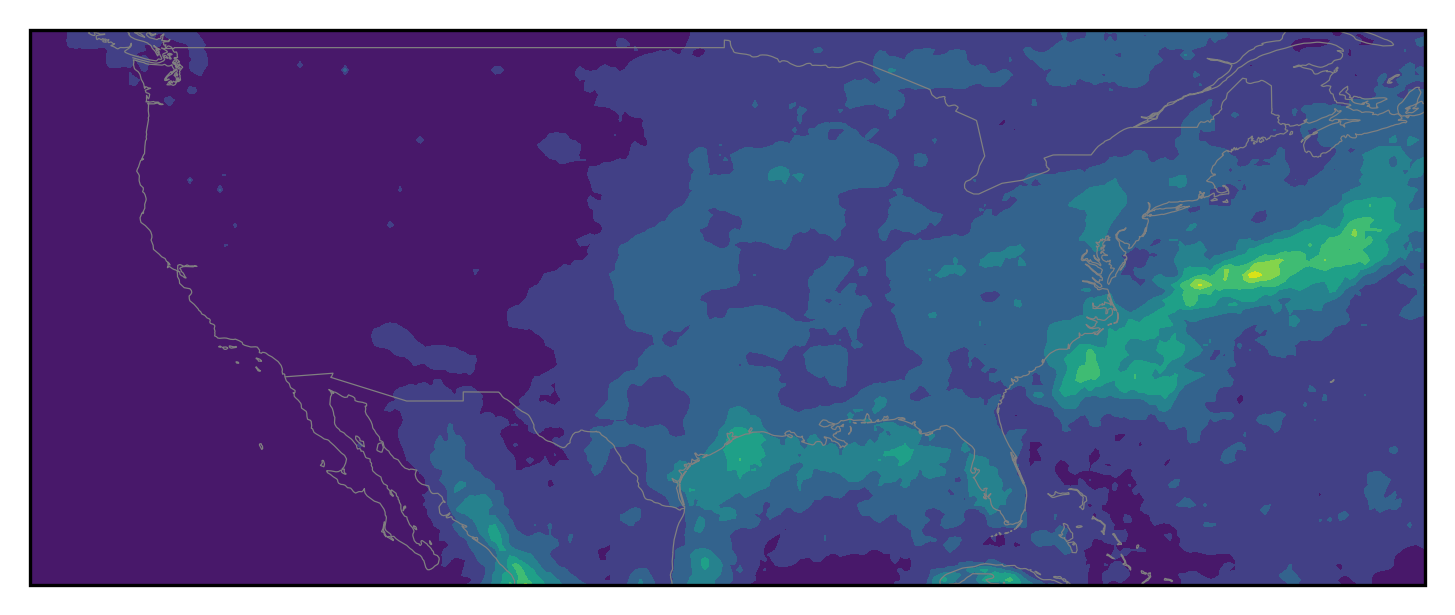

In [23]:
lon2d, lat2d = np.meshgrid(tmpalon, tmpalat)
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,6),dpi=300)
gs = gridspec.GridSpec(1,1)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.contourf(lon2d, lat2d, np.nansum(dset,axis=2).T)

In [24]:
x = da.from_array(dset, chunks=(6, 6, 300))

In [25]:
x

dask.array<array, shape=(280, 112, 1085), dtype=float32, chunksize=(6, 6, 300), chunktype=numpy.ndarray>

In [26]:
# UTC time
dates = [datetime.strptime(str(integd)+str(inthour), '%Y%m%d%H')
                    for integd, inthour in zip(dates_int, hours_int)]

In [27]:
# create xarray
xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                dims=('lon', 'lat', 'time'))

In [29]:
# set negative values to NaN (missing values)
xrs = xrs0.where(xrs0 >= -0.001)

In [30]:
# now extract a bounding box of interest:
clat = 34.785
clon = -98.125
dx = 0.25
npix = 3
buffer = 0.50*npix*dx
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer - eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer - eps

In [31]:
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [33]:
# selection in space
# pbox_3h = xrs.where(bcond, drop = True)
# load data to memory::
dt = 3 # timescale in hours
dx = 0.25
tmax = 48
# smax = 3

In [44]:
print(f'Actual latitude resolution : {tmpalat[1]-tmpalat[0]}')
print(f'Actual longitude resolution: {tmpalon[1]-tmpalon[0]}')

Actual latitude resolution : 0.25
Actual longitude resolution: 0.25


In [34]:
# XARRAY WITH VALUES LOADED IN MEMORY
box_3h = xrs.where(bcond, drop = True).load()

In [35]:
# aggregate to the daily scale propagating nans
# and only then remove nans
boxd0 = box_3h.resample(time ='D').sum(dim='time', skipna=False)

In [36]:
# compute correlation between gridded precipitation cells
res = down.grid_corr(boxd0, plot=False)

In [37]:
# res['fig'].show()
vdist = res['vdist']
vcorr = res['vcorr']
# res['fig'].show()
# res['d0']
# res['mu0']
# res['alpha']
# res['epsilon']
print(res)

{'vdist': array([22.87525134, 45.75046753, 27.79873166, 35.97869814, 53.47480907,
       55.59746332, 60.09316631, 71.91326393, 22.87525134, 35.97869814,
       27.79873166, 35.97869814, 60.09316631, 55.59746332, 60.09316631,
       53.47480907, 35.97869814, 27.79873166, 71.91326393, 60.09316631,
       55.59746332, 22.80611367, 45.61219185, 27.79873166, 35.93470863,
       53.35636272, 22.80611367, 35.93470863, 27.79873166, 35.93470863,
       53.35636272, 35.93470863, 27.79873166, 22.7365418 , 45.47304778,
       22.7365418 ]), 'vcorr': array([0.95152599, 0.86839861, 0.91062725, 0.93796754, 0.84752917,
       0.8987143 , 0.89380175, 0.88029599, 0.93889832, 0.91802591,
       0.95797437, 0.89784086, 0.91694587, 0.8952502 , 0.90318882,
       0.81868541, 0.90619034, 0.93236488, 0.84399503, 0.859743  ,
       0.88614094, 0.94608271, 0.81797075, 0.89257717, 0.87633592,
       0.85242766, 0.92739958, 0.95627135, 0.9498933 , 0.93325472,
       0.88371003, 0.90949756, 0.9493922 , 0.96093512

In [45]:
acftype = 'mar'
init_time = time.time()
# npoints = 5
resdown = down.down_corr(vdist, vcorr, 25.3, acf=acftype,
                        use_ave=True, opt_method = 'genetic',
                        toll=0.005, plot=True, disp=True)
print(resdown)
end_time = time.time()
exec_time = end_time - init_time
print('exec_time = {} minutes'.format(exec_time/60))

differential_evolution step 1: f(x)= 0.004562346996253442
differential_evolution step 2: f(x)= 0.004562346996253442
differential_evolution step 3: f(x)= 0.004562346996253442
differential_evolution step 4: f(x)= 0.0032594906480192076
differential_evolution step 5: f(x)= 0.0028973216882758057
Polishing solution with 'L-BFGS-B'


KeyboardInterrupt: 

In [ ]:
xx = np.linspace(0.5, 100)
corrL = down.int_corr(xx, (resdown['eps_d'], resdown['alp_d']), acftype, 25.3)